
<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analyzing Spot Diffraction Pattern

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CH2_08-Spot_Diffraction_Pattern.ipynb)

part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2022

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville|

Background and methods to analysis and quantification of data acquired with transmission electron microscopes


## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError):
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2022.1.2':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')

installing pyTEMlib
done


## Import numerical and plotting python packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,

and some libraries from the book
* kinematic scattering library.
* file_tools library

In [2]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab notebook

# additional package 
import  itertools 
import scipy.constants as const

import ipywidgets as ipyw

# Import libraries from the book

# Import libraries from pyTEMlib
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # Kinematic scattering Library
                             # Atomic form factors from Kirkland's book

### And we use the image tool library of pyTEMlib
import pyTEMlib.file_tools as ft
import pyTEMlib
print(pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib
Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher
0.2022.1.1


## Acquisition of Selected Area Diffraction Patterns

Practical steps:
- Make sure that area of interest is in focus.
- Insert SAD or equivalent aperture in image plane
- Remove objective aperture (let all the diffracted beams through)
- Focus the SAD aperture (Put's that aperture  in the image plane of the objective lens)
- Switch to diffraction mode 
- Adjust convergence angle  (C3) within the limits given by the area you want to investigate
- Focus the diffraction pattern with the intermediate lens (diffraction focus).
- Correct astigmatism 
- Block zero beam with the pointer. (You can damage the CCD)
- Use long exposer times ($>$ 1 sec: better dynamics, sharper pattern) or even take several at different exposure times. 

>**Some tips:**
>- cooling the specimen will reduce thermal diffuse scattering (scattering at phonons).
>
>- With a Gatan Image Filter (GIF) or an in-column filter one can filter out the inelastic scattering  (lower energy) electrons responsible for a lot of the background intensity.
>
>- CCD cameras usually have a lower dynamic range  and can be easily damaged by the zero refection. Summing several diffraction-pattern increases the dynamic range of the data.
>
>- Changes in the lattice parameter due to stress will not be easily seen in the diffraction patterns, but HOLZ line patterns (later) give that level of accuracy.


## Load Spot-Diffraction Pattern

First we select the diffraction pattern

C:\Users\gdusc\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:350: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<IPython.core.display.Javascript object>


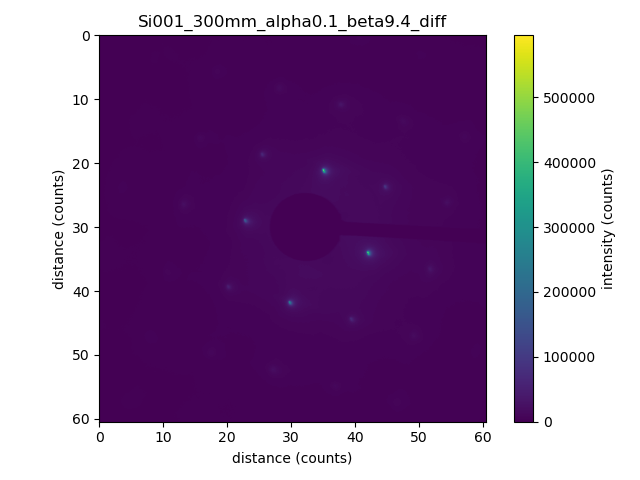

<IPython.core.display.Javascript object>


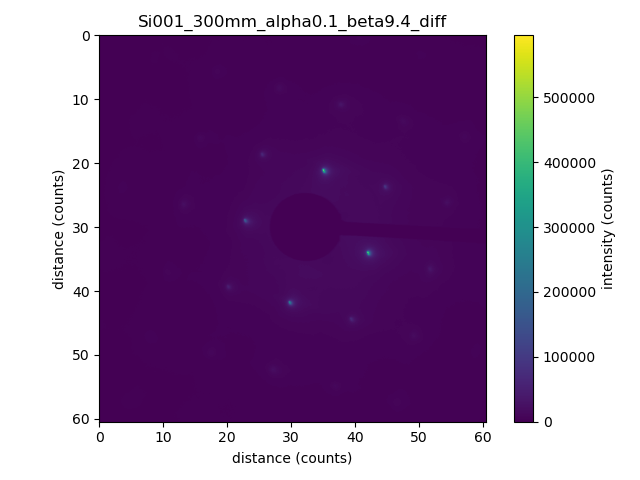

In [3]:
file_name = '..\\example_data\\Si001_300mm_alpha0.1_beta9.4_diff.dm3'
sidpy_dataset = ft.open_file(file_name)
sidpy_dataset.plot()

### Plotting on a logarithmic scale

The dynamic range in diffraction data is even larger than in images and so for a good presentation of the data it is advantageous to go to plot the intensities in a logarithmic scale.

To present data in logarithmic scale no negative values (noise) can be in these data and so all negative values in the dataset will be set to zero.

The factor 1 in front of the diffraction pattern in the log numpy function in the ``imshow`` is the gamma value.
Changing that value will change the contrast.

<IPython.core.display.Javascript object>


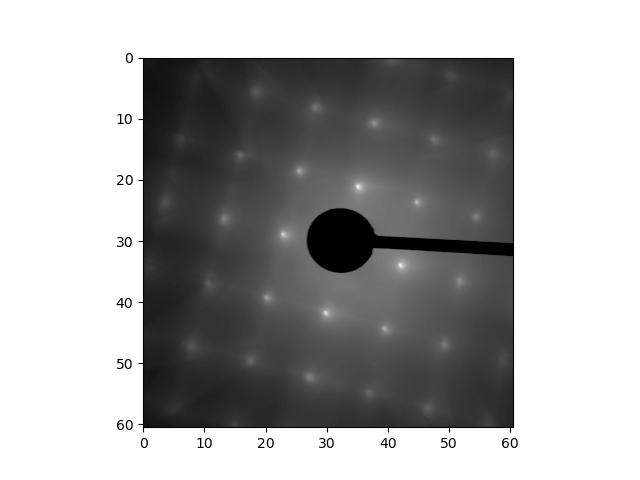

In [4]:
diff_pattern = np.array(sidpy_dataset).T
diff_pattern[diff_pattern<0] = 0.
extent = sidpy_dataset.get_extent([0,1])
fig = plt.figure() 
plt.imshow(np.log(1+diff_pattern),cmap="gray", vmin=np.max(np.log(1+diff_pattern))*0.5, extent=extent);
scale_300mm = 0.012829394079744816

## Finding the center

First try with cross correlation of rotated images


### Finding the center of the beam-stop

The beam-stop is naturally dark, and we first select the dark regions.
These dark regions are naturally spotty, and we set all small values to

We first find the maximum of the profile for the 


1101 1016.5


<IPython.core.display.Javascript object>


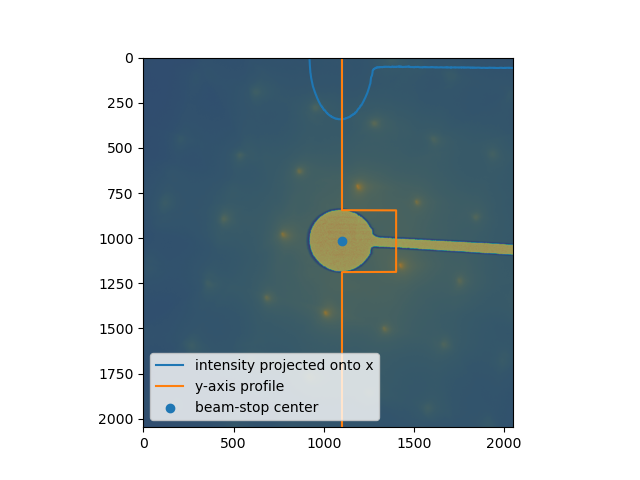

In [5]:
import scipy.ndimage as ndimage

beam_stop = np.zeros(diff_pattern.shape)
beam_stop[diff_pattern < 100] = 1
beam_stop = ndimage.gaussian_filter(beam_stop, sigma=(2, 2), order=0)
beam_stop[beam_stop <= .7] = 0
beam_stop[beam_stop > .7] = 1

# Find maximum of intensity onto x-axis
center_x = np.argmax(beam_stop.sum(axis=0))

# Find center of y-axis line profile at position center_x
center_y = np.average(np.where(beam_stop[:,center_x]>0.7))

print(center_x, center_y)
center = np.array([center_x, center_y])
plt.figure()
plt.imshow(np.log(1+diff_pattern))
plt.imshow(beam_stop, alpha=0.5)
plt.plot(beam_stop.sum(axis=0), label= 'intensity projected onto x')
plt.plot(center_x+beam_stop[:,center_x]*300, np.arange(2048) , label='y-axis profile')

plt.scatter(center[0], center[1], label='beam-stop center')
plt.legend(loc='lower left');

## Determine Bragg Peaks

Peak finding is actually not as simple as it looks

In [7]:
# our blob detectors from the scipy image package
from skimage.feature import blob_dog

<IPython.core.display.Javascript object>


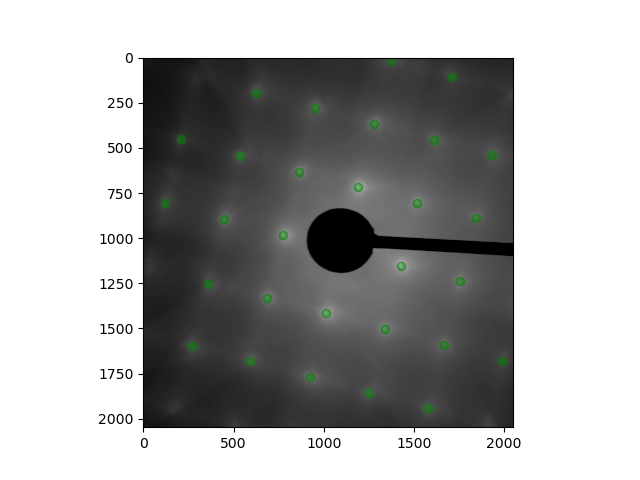

In [8]:

# The beam stop is rather dark
beam_stop = np.argwhere(diff_pattern.T < 50)

# Determine all spots

dif = np.log2(1+diff_pattern).T
dif = dif-dif.min() # blog detector does not like negative values
spots = blob_dog(dif, max_sigma=12, threshold=.9)

Bragg_spots = []

plt.figure()
plt.imshow(np.log2(1+diff_pattern),cmap="gray", vmin=np.max(np.log2(1+diff_pattern))*0.5)

# We only consider spots not associated with the beam stop (which confuses the blob finder)
for spot in spots:
    if np.min(np.linalg.norm(beam_stop-spot[:2], axis=1))> 50:
        Bragg_spots.append(spot[0:2])
Bragg_spots = np.array(Bragg_spots)
Bragg_spots = Bragg_spots[np.argsort(np.linalg.norm(Bragg_spots[:,:2]-center, axis=1)),:]
plt.scatter(Bragg_spots[:,0], Bragg_spots[:,1], c='green',  alpha = 0.5)




### Refine Center

We use the N innermost reflections and the average of those positions is the new center

<IPython.core.display.Javascript object>


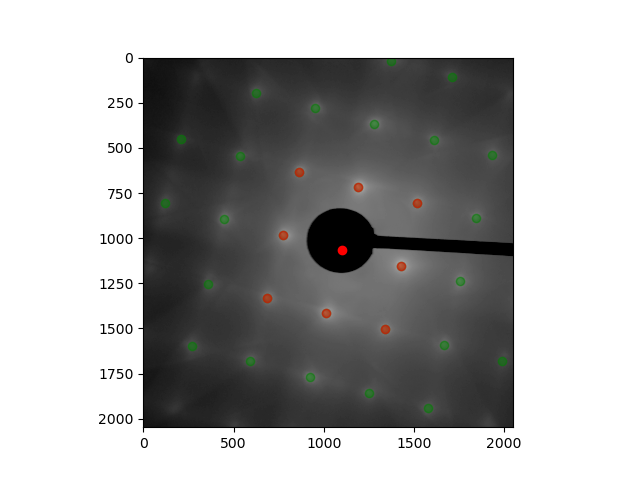

In [9]:
# -------INPUT-----------
number_of_reflections = 8
#------------------------

if number_of_reflections%2 !=0:
    print('Because of inversion symmetry we need an even number')

plt.figure()
plt.imshow(np.log2(1+diff_pattern),cmap="gray", vmin=np.max(np.log2(1+diff_pattern))*0.5)
plt.scatter(Bragg_spots[:,0], Bragg_spots[:,1], c='green',  alpha = 0.5)
plt.scatter(Bragg_spots[:number_of_reflections,0], Bragg_spots[:number_of_reflections,1], c='red',  alpha=0.5)
new_center = np.average(Bragg_spots[:number_of_reflections,:2],axis=0)
plt.scatter(new_center[0], new_center[1], color='red')



### Now we plot with the right scale

<IPython.core.display.Javascript object>


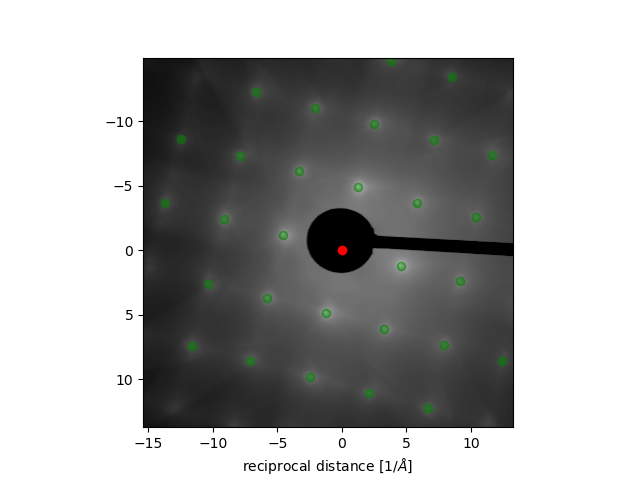

In [28]:
center = new_center
g = gx = gy = ft.get_slope(sidpy_dataset.x.values)
g = gx = gy = scale_300mm*1.09
#gx = gy * 1.05

spots_experiment = (Bragg_spots-(center[0],center[1]))*(gx,gy)

fig = plt.figure()
extent= np.array([-center[0]*gx, (diff_pattern.shape[0]-center[0])*gx,(diff_pattern.shape[1]-center[1])*gy, -center[1]*gy])

plt.imshow(np.log2(1+diff_pattern), cmap="gray", extent=extent, vmin=np.max(np.log2(1 + diff_pattern)) * 0.5)

plt.scatter(spots_experiment[:,0], spots_experiment[:,1], c='green',  alpha = 0.5,
           label='spots')
plt.xlabel('reciprocal distance [1/$\AA$]')
plt.scatter(0,0, color='red')


### The norm of the reflections 
will show us how accurate our center was determined and what give us a first idea on what zone axis we have.
If the center is accurate, we should have always a number of spots with the same distance from center (norm of reciprocal lattice vector) according to symmetry (in [001] direction always 4 reciprocal lattice vectors with the same length)

In [27]:
print('reciprocal distances in 1/nm')
print(np.sort(np.linalg.norm(spots_experiment,axis=1)))


reciprocal distances in 1/nm
[ 47.02835047  47.09597657  50.44262542  50.45997088  68.90717078
  68.96617435  69.37412994  69.40738407  94.24353698  94.4464072
 101.09714097 101.52093081 106.65090859 106.85323599 107.68571366
 107.73700242 111.25587197 111.42680786 112.17037478 112.48391573
 138.01547902 138.19240657 139.27203471 139.38330114 141.97153244
 150.9829695  151.50239083 151.77469029 159.25744865]


## Calculate Spot Pattern

see [Plotting of Diffraction Pattern](CH2_07-Plotting_Diffraction_Pattern.ipynb) for details


In [15]:
atoms  = ks.structure_by_name('silicon')
atoms.info['experimental']={}
### Define experimental parameters:
atoms.info['experimental']['acceleration_voltage_V'] = 200.0 *1000.0 #V
atoms.info['experimental']['new_figure'] = False
atoms.info['experimental']['plot FOV'] = 30
atoms.info['experimental']['convergence_angle_mrad'] = 0
atoms.info['experimental']['zone_hkl'] = np.array([0,0,1])  # incident nearest zone axis: defines Laue Zones!!!!
atoms.info['experimental']['mistilt']  = np.array([0,0,0])  # mistilt in degrees
atoms.info['experimental']['Sg_max'] = .4 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
atoms.info['experimental']['hkl_max'] = 15   # Highest evaluated Miller indices

######################################
# Diffraction Simulation of Crystal #
######################################

d = ks.kinematic_scattering(atoms, verbose = True)


reciprocal_unit_cell
[[0.184 0.    0.   ]
 [0.    0.184 0.   ]
 [0.    0.    0.184]]
The inner potential is 36177.0V
Using an acceleration voltage of 200.0kV
Magnitude of incident wave vector in material: 194.3 1/Ang and in vacuum: 39.9 1/Ang
Which is an wave length of 0.515 pm in the material and 2.508 pm in the vacuum
The convergence angle of 0.0mrad = 0.00 1/A
Magnitude of incident wave vector in material: 194.3 1/A which is a wavelength 0.515 pm
Rotation alpha 0.0 degree,  beta 0.0 degree
from zone axis [0 0 1]
Tilting 1 by 0.00  in alpha and 0.00 in beta direction results in :
Next nearest zone axes are:
Center of Ewald sphere  [  0.           0.         194.33716325]
Of the 29790 tested reciprocal_unit_cell points, 4764 have an excitation error less than 0.40 1/nm
Of the 4764 possible reflection 848 are allowed.
Of the 3916 forbidden reflection 3916 can be dynamically activated.
[[-15. -15.   0.]
 [-15. -15.   0.]
 [-15. -15.   0.]
 ...
 [-15. -15.   0.]
 [-15. -15.   0.]
 [-15. 

 [ 9.  7. -1.] 	 [ 1.65718999  1.28892555 -0.18413222] 	 0.982 	  0.684 	  2.107   
 [9. 7. 1.] 	 [1.65718999 1.28892555 0.18413222] 	 0.982 	  0.684 	  2.107   
 [ 9.  9. -1.] 	 [ 1.65718999  1.65718999 -0.18413222] 	 0.675 	  0.516 	  2.351   
 [9. 9. 1.] 	 [1.65718999 1.65718999 0.18413222] 	 0.675 	  0.516 	  2.351   
 [ 9. 11. -1.] 	 [ 1.65718999  2.02545444 -0.18413222] 	 0.457 	  0.376 	  2.623   
 [ 9. 11.  1.] 	 [1.65718999 2.02545444 0.18413222] 	 0.457 	  0.376 	  2.623   
 [ 9. 13. -1.] 	 [ 1.65718999  2.39371888 -0.18413222] 	 0.310 	  0.270 	  2.917   
 [ 9. 13.  1.] 	 [1.65718999 2.39371888 0.18413222] 	 0.310 	  0.270 	  2.917   
 [ 9. 15. -1.] 	 [ 1.65718999  2.76198332 -0.18413222] 	 0.212 	  0.192 	  3.226   
 [ 9. 15.  1.] 	 [1.65718999 2.76198332 0.18413222] 	 0.212 	  0.192 	  3.226   
 [ 10. -14.   0.] 	 [ 1.84132222 -2.5778511   0.        ] 	 0.908 	  0.646 	  3.168   
 [ 10. -12.  -2.] 	 [ 1.84132222 -2.20958666 -0.36826444] 	 1.266 	  0.818 	  2.900   
 [ 10. 

done


## Plotting Experimental and Simulated Spot Diffraction Patterns

In [22]:
atoms.info.keys()

dict_keys(['structure', 'title', 'experimental', 'output', 'diffraction'])

<IPython.core.display.Javascript object>


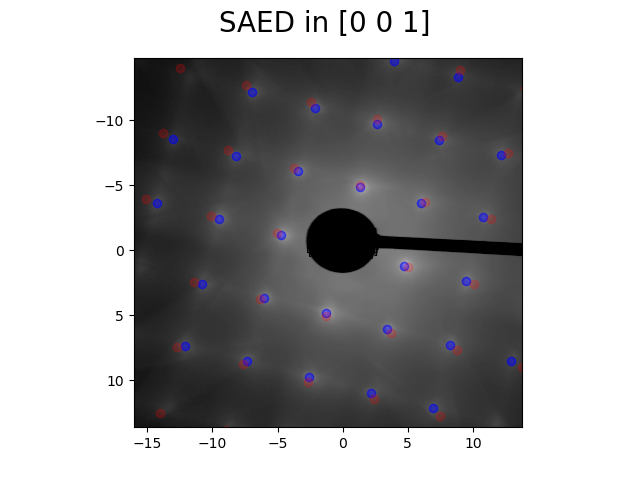

In [31]:
tags_simulation = atoms.info['diffraction']
g = gx = gy = ft.get_slope(sidpy_dataset.x.values)
g = gx = gy = scale_300mm*1.08
gx = gy * 1.05

extent= np.array([-center[0]*gx, (diff_pattern.shape[0]-center[0])*gx,(diff_pattern.shape[1]-center[1])*gy, -center[1]*gy])

angle = np.radians(-59.6)
c = np.cos(angle)
s = np.sin(angle)
r_mat = np.array([[c,-s,0],[s,c,0],[0,0,1]])
rmat_g= r_mat

spots_experiment = (Bragg_spots-(center[0],center[1]))*(gx,gy)

spots_simulation =  np.dot(tags_simulation['allowed']['g'],r_mat)
spots_ZOLZ = spots_simulation[tags_simulation['allowed']['ZOLZ']]*10
fig = plt.figure()
fig.suptitle(' SAED in ' + str( atoms.info['experimental']['zone_hkl']), fontsize=20) 
plt.scatter(spots_experiment[:,0], spots_experiment[:,1], c='blue',  alpha = 0.5, label='spots')
plt.scatter(spots_ZOLZ[:,0], spots_ZOLZ[:,1], c='red',  alpha = 0.2,   label='spots')
plt.imshow(np.log2(1+diff_pattern), cmap="gray", extent=extent, vmin=np.max(np.log2(1 + diff_pattern)) * 0.5)

for i in range(len(tags_simulation['allowed']['g'])):
    if np.linalg.norm(tags_simulation['allowed']['g'][i]) <.8:
        plt.text(spots_simulation[i,0], spots_simulation[i,1],str(tags_simulation['allowed']['hkl'][i]),
                fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')
    

### What does the above figure convey?

* center is determined accurately
* relative distances are accurately described
* scaling accurately for reference crystal - calibration?
* diffraction pattern is indexed



### What is the accuracy?

Change the scale by 1% and see what happens

So we can determine the lattice parameter better than 1% if we use high scattering angles!

Objective stigmation is critical to resolve angles well.

Illumination stigmation determines size of Bragg spots.


## Conclusion

We need more information for the spot pattern than for the ring pattern.

A comparison between simulation and experiment can be very precise.

In principle, if you have the spots and the approximate center you can let an optimization routine do all the scaling for you (which we will do in the high resolution imaging section).



## Navigation

- <font size = "3">  **Back: [Plotting Diffraction Pattern](CH2_07-Plotting_Diffraction_Pattern.ipynb)** </font>
- <font size = "3">  **Next: [Unit Cell Determination](CH2_09-Unit_Cell.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>


## Appendix 

reciprocal_unit_cell
[[1.764 0.    0.   ]
 [0.    1.764 0.   ]
 [0.    0.    1.764]]
The inner potential is 0.001kV
Magnitude of incident wave vector in material 205.5 1/nm and vacuum 205.5 1/nm
The convergence angle of 0mrad = 0.00 1/nm
Rotation angles are 45.0 deg and 90.0 deg
Center of Ewald sphere  [-2.39288115e-14  8.89798152e-15  2.05506537e+02]
Of the 29790 tested reciprocal_unit_cell points, 546 have an excitation error less than 0.40 1/nm
Of the 546 possible reflection 114 are allowed.
 There are 46 allowed reflections in the zero order Laue Zone
 There are 0 allowed reflections in the first order Laue Zone
 There are 68 allowed reflections in the second order Laue Zone
 There are 0 allowed reflections in the other higher order Laue Zones
Length of zone axis vector in real space 0.802 nm
There are 16 forbidden but dynamical activated diffraction spots:
KinsCat's  "Kinematic_Scattering" finished


<IPython.core.display.Javascript object>


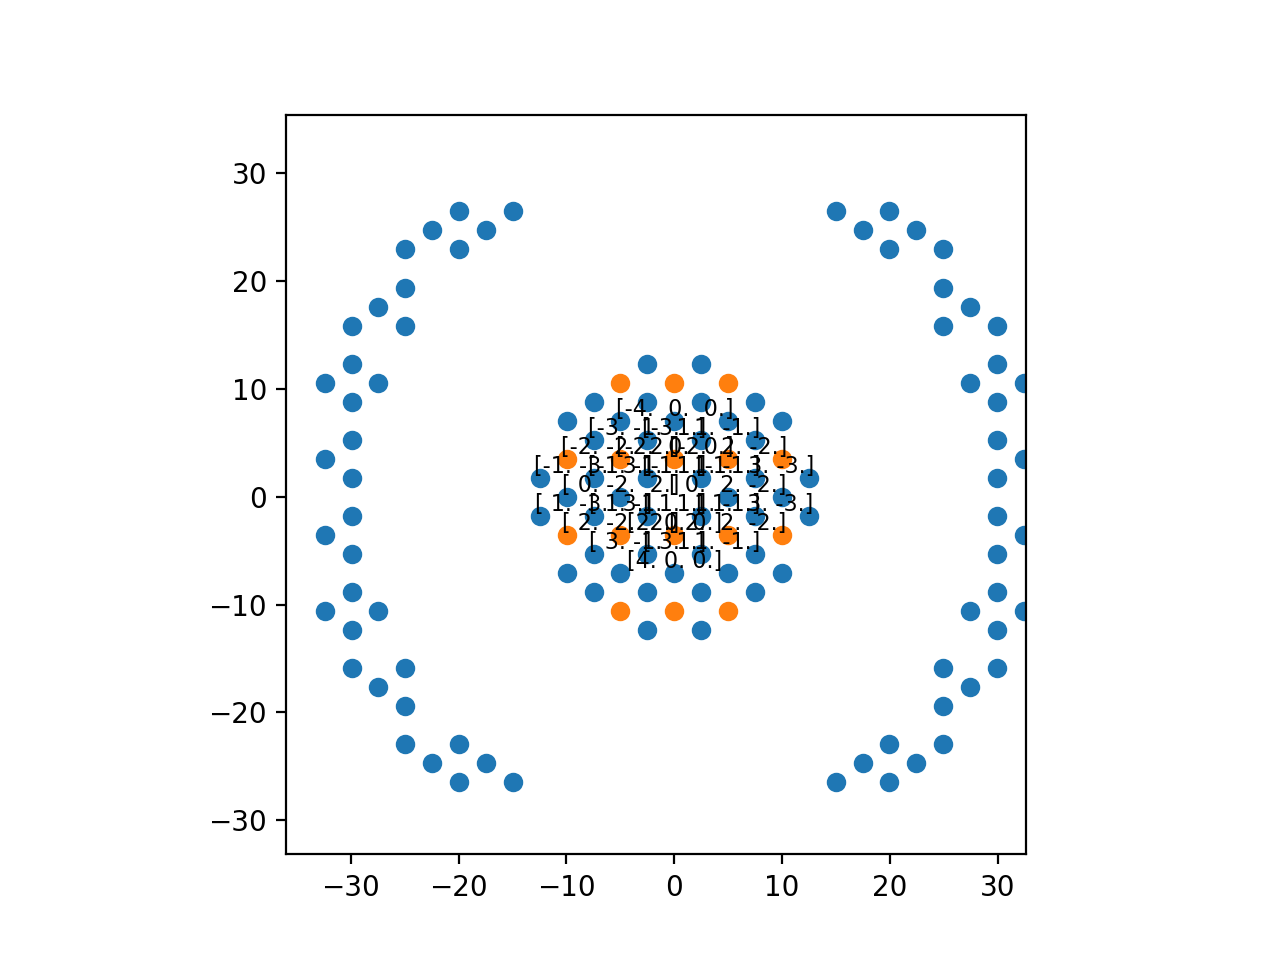

In [38]:
#######################################
# Diffraction Simulation of a Crystal #
#######################################
tags_simulation['zone_hkl'] = np.array([0,1,1])  # incident nearest zone axis: defines Laue Zones!!!!
tags_simulation['acceleration_voltage_V'] = 60.0 *1000.0 #V
ks.kinematic_scattering(tags_simulation, verbose = True)
plt.figure()
plt.scatter(tags_simulation['allowed']['g'][:,0],tags_simulation['allowed']['g'][:,1])
dynamic_allowed = tags_simulation['forbidden']['g'][tags_simulation['forbidden']['dynamically_activated']]
plt.scatter(dynamic_allowed[:,0],dynamic_allowed[:,1])


for i in range(len(tags_simulation['allowed']['g'])):
    if np.linalg.norm(tags_simulation['allowed']['g'][i]) <8:
        plt.text(tags_simulation['allowed']['g'][i,0], tags_simulation['allowed']['g'][i,1],str(tags_simulation['allowed']['hkl'][i]),
                fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')

for i in range(len(dynamic_allowed)):
    if np.linalg.norm(dynamic_allowed[i]) <8:
        plt.text(dynamic_allowed[i,0], dynamic_allowed[i,1],str(tags_simulation['forbidden']['hkl'][tags_simulation['forbidden']['dynamically_activated'][i]]),
                fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')
plt.xlim(-12,12)
plt.ylim(-12,12)
plt.gca().set_aspect('equal')
